# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

In [1]:
# Basic pandas and numpy
import pandas as pd
import numpy as np
 
# Basic visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
 
# Make jupyter bigger
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [2]:
houses = pd.read_csv('../data/boston_data.csv')

In [3]:
houses.shape

(404, 14)

In [4]:
houses.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [5]:
houses.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [6]:
houses.describe().T

,count,mean,std,min,25%,50%,75%,max
crim,404.0,3.730912,8.943922,0.00632,0.082382,0.253715,4.053158,88.9762
zn,404.0,10.509901,22.053733,0.00000,0.000000,0.000000,12.500000,95.0000
indus,404.0,11.189901,6.814909,0.46000,5.190000,9.795000,18.100000,27.7400
chas,404.0,0.069307,0.254290,0.00000,0.000000,0.000000,0.000000,1.0000
nox,404.0,0.556710,0.117321,0.39200,0.453000,0.538000,0.631000,0.8710
rm,404.0,6.301450,0.675830,3.56100,5.902750,6.230500,6.629250,8.7800
age,404.0,68.601733,28.066143,2.90000,45.800000,76.600000,94.150000,100.0000
dis,404.0,3.799666,2.109916,1.16910,2.087875,3.207450,5.222125,12.1265
rad,404.0,9.836634,8.834741,1.00000,4.000000,5.000000,24.000000,24.0000
tax,404.0,411.688119,171.073553,187.00000,281.000000,330.000000,666.000000,711.0000


In [7]:
1

houses.dtypes

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

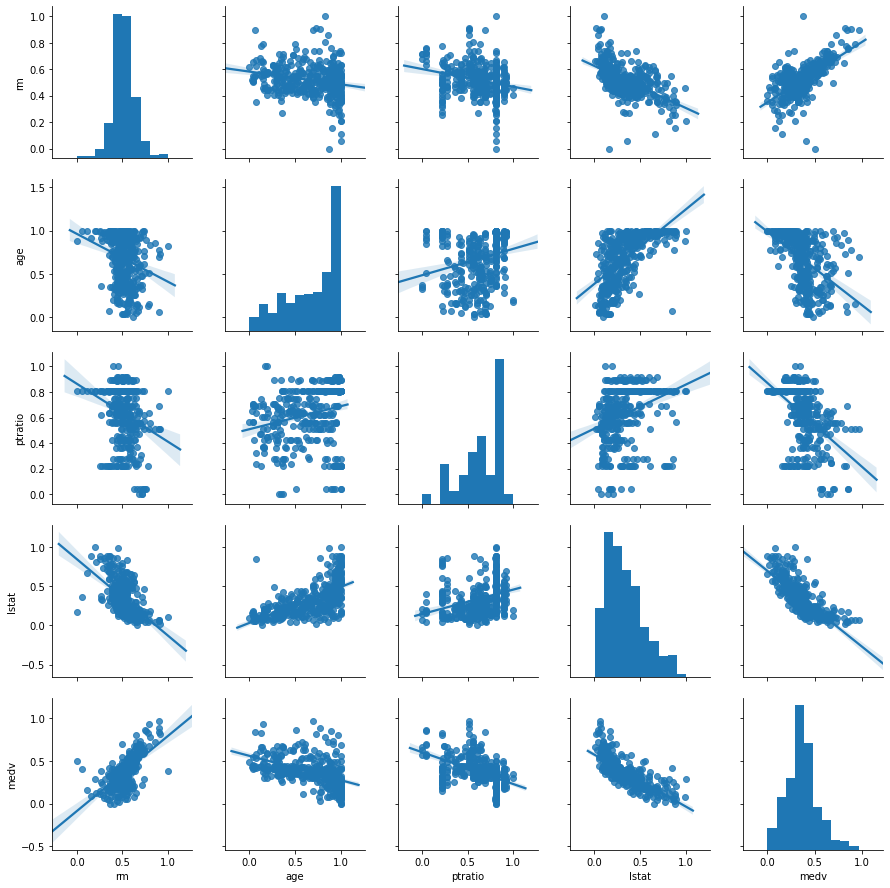

In [20]:
used = ['rm', 'age', 'ptratio', 'lstat', 'medv']
sns.pairplot(houses[used], kind='reg')

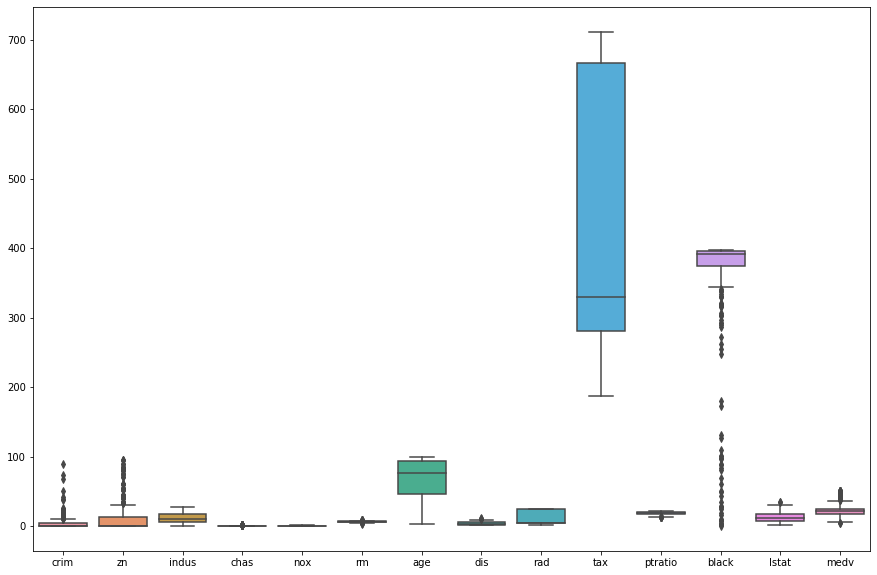

In [9]:
plt.figure(figsize=(15,10))
sns.boxplot(data=houses)

In [10]:
# There is variability on the magnitudes of variables, so I scale them and plot them again

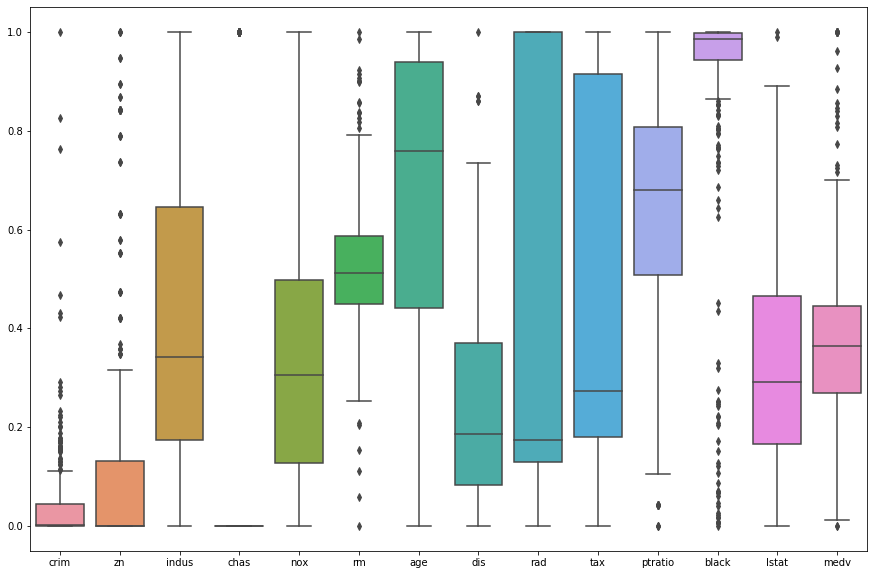

In [11]:
# Scaling:
from sklearn.preprocessing import MinMaxScaler

for col in list(houses.columns):
    houses[col] = MinMaxScaler().fit_transform(houses[col].values.reshape(-1,1))

# Replotting:
plt.figure(figsize=(15,10))
sns.boxplot(data=houses)

In [12]:
q1, q3 = np.percentile(houses['medv'], [25,75])
iqr = q3-q1
upper_fence = q3 + 3 * iqr
lower_fence = q1 - 3 * iqr

In [13]:
houses.medv = houses.medv.loc[(houses.medv > lower_fence) & (houses.medv < upper_fence)]

In [14]:
houses.dropna(inplace=True)

In [15]:
houses.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

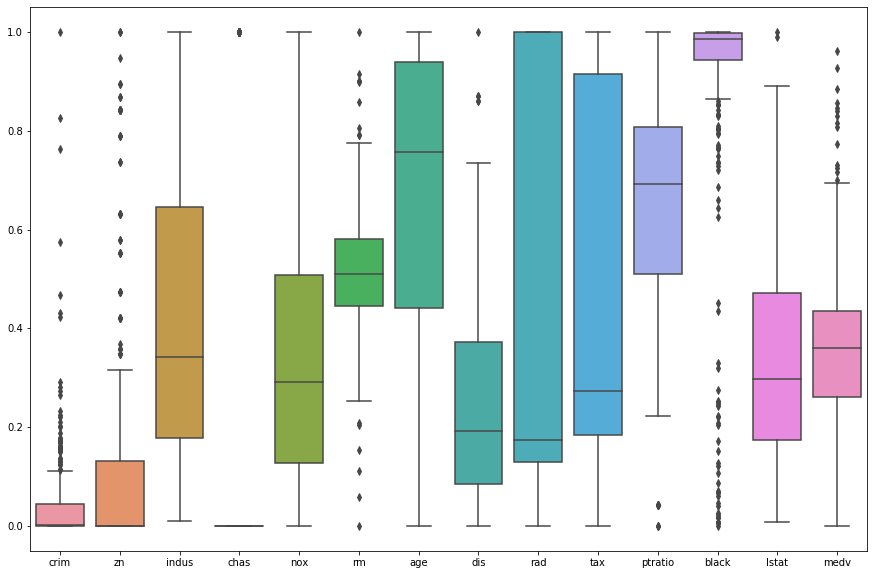

In [16]:
plt.figure(figsize=(15,10))
sns.boxplot(data=houses)

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [17]:
# rm (number of rooms) seems to be the the most directly correlated. 
# lstat (lower status correlation) seems to be the the most inversely correlated. 
# age and ptratio (pupil-teacher ratios) are somehow inversely correlated.
# Black has a lot of outliers, I will try to figure if there is colinearity with other variable to see if I can put that column aside. [I did it and I did not find significant colinearity].

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

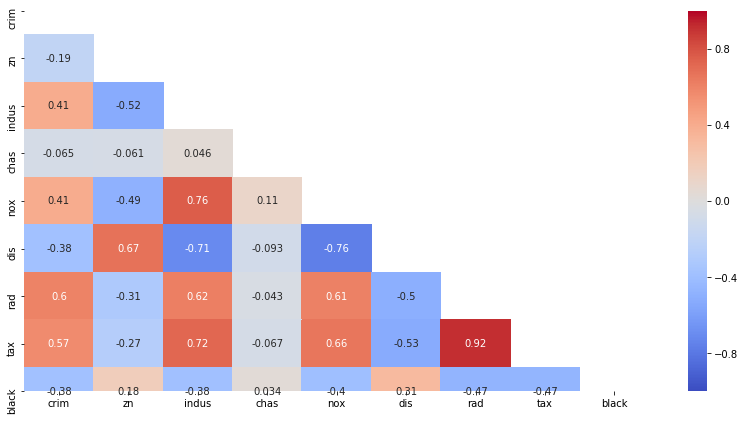

In [21]:
# Set Variables:
cormat = houses[[col for col in list(houses.columns) if col not in used]].corr()
figsize = (14, 7)
vmin= -1 # Sets maximum color
vmax= 1 # Sets minimum color
cmap = 'coolwarm' # Palette
 
# Create mask for upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
 
# Plot figure:
plt.figure(figsize=figsize)
sns.heatmap(cormat,
vmin=vmin, vmax=vmax,
cmap=cmap,
annot=True,
mask= mask)

In [22]:
# Maybe zone is somehow directly correlated.

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [23]:
houses.describe()['medv']

count    392.000000
mean       0.365884
std        0.166655
min        0.000000
25%        0.261667
50%        0.360000
75%        0.436111
max        0.962222
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [24]:
from sklearn.metrics import r2_score

def performance_metric(y_train, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_train, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [25]:
from sklearn.model_selection import train_test_split

houses_X = houses[[col for col in list(houses.columns) if col != 'medv']]
houses_y = houses['medv']

X_train, X_test, y_train, y_test = train_test_split(houses_X, 
                                                    houses_y, 
                                                    test_size=0.25,
                                                    random_state=20,
                                                    shuffle=True)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
max_depths = [2, 4, 6, 8, 10]
dict_train = {}
dict_test = {}

for i in max_depths:
    max_depth = i
    RFR = RandomForestRegressor(n_estimators=10, max_depth=max_depth).fit(X_train, y_train)
    y_predict_train = RFR.predict(X_train)
    y_predict_test = RFR.predict(X_test)
    r2_train = performance_metric(y_train, y_predict_train)
    r2_test = performance_metric(y_test, y_predict_test)
    dict_train[str(i)] = r2_train
    dict_test[str(i)] = r2_test    

Now, plot the score for each tree on the training set and on the testing set.

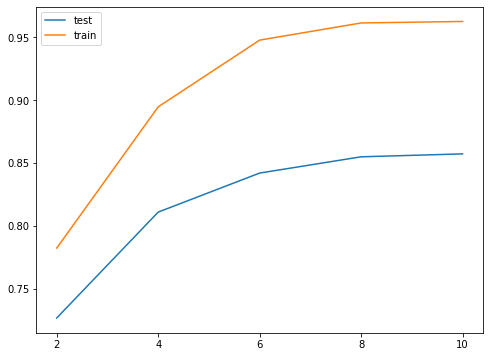

In [29]:
# Produce a plot with the score for the testing and training for the different max depths
plt.figure(figsize=(8,6))
plt.plot(*zip(*(dict_test.items())), label='test')
plt.plot(*zip(*(dict_train.items())), label='train')
plt.legend()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [30]:
# It comes to a point (8) where the predictions do not improve.

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [ ]:
# Your response here

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [ ]:
# Your response here

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here